In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [2]:
# torch package
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# dataset packagea
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# metrcis
from sklearn.metrics import accuracy_score, classification_report

# ETC
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# AlexNet-Model

In [3]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        [(H_in + 2P - K)/S] + 1
        '''

        self.conv_layer1 = nn.Sequential(\
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0))

        self.conv_layer2 = nn.Sequential(\
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0))

        self.conv_layer3 = nn.Sequential(\
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())

        self.conv_layer4 = nn.Sequential(\
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())

        self.conv_layer5 = nn.Sequential(\
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.dense_layer = nn.Sequential(\
            nn.Linear(256 * 13 * 13, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)) # 원래는 ImageNet data에 맞게 class가 1000이지만 용량 이슈로 인해 CIFAR10을 사용해서 output을 10으로 설정.


    def forward(self, x):
        # (batch_size, 3, 227, 227)
        out = self.conv_layer1(x)
        # (batch_size, 96, 27, 27)
        out = self.conv_layer2(out)
        # (batch_size, 256, 13, 13)
        out = self.conv_layer3(out)
        # (batch_size, 384, 13, 13)
        out = self.conv_layer4(out)
        # (batch_size, 384, 13, 13)
        out = self.conv_layer5(out)
        # (batch_size, 256, 13, 13)
        out = out.view(out.size(0), -1)
        # (batch_size, 256 * 13 * 13)
        alexnet_out = self.dense_layer(out)
        # (batch_size, 10)

        return alexnet_out

# Train

In [4]:
def train(model, config, train, valid, optimizer=False, loss=False):
    train_loss_history = []
    valid_loss_history = []

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    loss_function = nn.CrossEntropyLoss()


    for i in range(config.epochs):

        train_loss_ = 0
        model.train()
        with torch.enable_grad():
            for feature, label in train:
                feature, label = feature.to(config.device), label.to(config.device)
                optimizer.zero_grad()
                outputs = model(feature)

                loss = loss_function(outputs, label)

                loss.backward()
                optimizer.step()

                train_loss_ += loss.item()

        train_loss_ /= config.batch_size
        train_loss_history.append(train_loss_)



        valid_loss_ = 0
        model.eval()
        with torch.no_grad():
            for feature, label in valid:
                feature, label = feature.to(config.device), label.to(config.device)
                # outputs = model(feature.view(config.batch_size, 1, 28, 28))
                outputs = model(feature)

                loss = loss_function(outputs, label)

                valid_loss_ += loss.item()

        valid_loss_ /= config.batch_size
        valid_loss_history.append(valid_loss_)

        clear_output(wait=True) # 주피터 셀 초기화

        history_print = []
        # if (i+1)%int((config.epochs)*0.1)==0:
        log = f"epoch : {i+1} Loss(train) : {train_loss_history[-1]:.3f}  Loss(valid) : {valid_loss_history[-1]:.3f}"
        history_print.append(log)
        for log in history_print[-5:-1]:
            print(log)

        plt.plot(train_loss_history, label='Training loss')
        plt.plot(valid_loss_history, label='Validation loss')
        plt.ylim(0, 5)
        plt.legend()
        plt.show()



    print("="*40)
    print("Training loss: ", train_loss_history[-1])
    print("Validation loss: ", valid_loss_history[-1])
    print("="*40)

# Predict

In [20]:
def predict_evaluate(model, config, test):
    model.eval()
    acc = []

    y_pred = torch.Tensor()
    y_test = torch.Tensor()
    with torch.no_grad():
        for feature, label in test:
            feature, label = feature.to(config.device), label.to(config.device)
            outputs = model(feature)
            outputs = outputs.cpu()
            _, outputs = torch.max(outputs, 1)

            label = label.cpu()

            acc.append(accuracy_score(label, outputs))
            y_pred = torch.cat((y_pred, outputs), dim=0)
            y_test = torch.cat((y_test, label), dim=0)


    print(f"Accuracy: {(sum(acc)/len(acc)):.3f}")

    return y_test, y_pred

# Hyperparameter config

In [6]:
class config():
    def __init__(self, device, learning_rate=0.001, epochs=100, batch_size = 128):
        self.learning_rate = learning_rate

        self.batch_size = batch_size
        self.epochs = epochs

        self.device = device

# Dataset

In [7]:
batch_size = 2**8

In [8]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True) # 48000
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True) # 12000
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)  # 10000

Files already downloaded and verified
Files already downloaded and verified


# Model

In [9]:
train_config = config(device = device,
                      learning_rate=0.001,
                      epochs = 30,
                      batch_size = batch_size)

In [10]:
AlexNet = AlexNet().to(device)

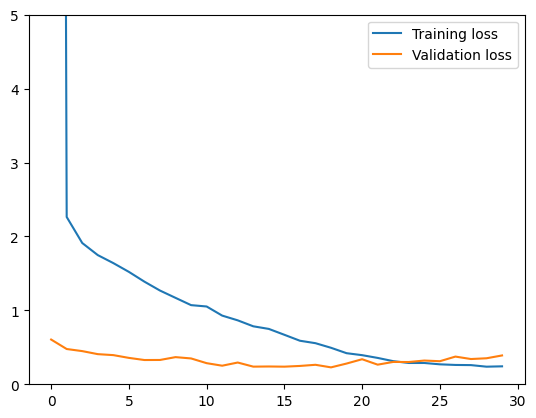

Training loss:  0.2427960821223678
Validation loss:  0.38997811102308333


In [11]:
train(AlexNet, train_config, train_loader, valid_loader)

# Evaluation

In [21]:
y_test, y_pred = predict_evaluate(AlexNet, train_config, test_loader)

Accuracy: 0.756


In [22]:
y_test

tensor([3., 8., 8.,  ..., 5., 1., 7.])

In [23]:
y_pred

tensor([5., 8., 8.,  ..., 5., 1., 7.])

In [24]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.73      0.78      1000
         1.0       0.86      0.84      0.85      1000
         2.0       0.71      0.60      0.65      1000
         3.0       0.58      0.57      0.58      1000
         4.0       0.70      0.77      0.73      1000
         5.0       0.69      0.68      0.68      1000
         6.0       0.73      0.87      0.79      1000
         7.0       0.78      0.81      0.80      1000
         8.0       0.84      0.85      0.84      1000
         9.0       0.86      0.81      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000

